In [1]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### Prepare for Dataset

In [2]:
all_chars       = string.printable
n_chars         = len(all_chars)
file            = open('./shakespeare.txt').read()
file_len        = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 1115394
All possible characters: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Number of all possible characters: 100


In [3]:
# Get a random sequence of the Shakespeare dataset.
def get_random_seq():
    seq_len     = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), 1, n_chars) 
    # Shape of the tensor:
    #     (sequence length, batch size, classes)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, char in enumerate(seq):
        index = all_chars.index(char)
        tensor[t][0][index] = 1
    return tensor

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char)
    return tensor

# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = seq_to_onehot(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]).long() # Target is represented in index.
    return input, target

#### Choose a Device

In [4]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


#### Network Definition

In [5]:
class Net(nn.Module):
    def __init__(self):
        # Initialization.
        super(Net, self).__init__()
        self.input_size  = n_chars   # Input size: Number of unique chars.
        self.hidden_size = 100       # Hidden size: 100.
        self.output_size = n_chars   # Output size: Number of unique chars.
        
        self.func1 = nn.RNNCell(self.input_size, self.hidden_size, nonlinearity='relu')
        self.func2 = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, input, hidden):
        """ Forward function.
              input:  One-hot input. It refers to the x_t in homework write-up.
              hidden: Previous hidden state. It refers to the h_{t-1}.
            Returns (output, hidden) where output refers to y_t and 
                     hidden refers to h_t.
        """
        # Forward function.
        hidden = self.func1(input, hidden)
        output = self.func2(hidden)

        return output, hidden

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
        return torch.zeros(1, self.hidden_size).to(device) 
    
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (func1): RNNCell(100, 100, nonlinearity=relu)
  (func2): Linear(in_features=100, out_features=100, bias=True)
)

#### Training Step and Evaluation Step

In [6]:
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.
    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.

    for t in range(seq_len):    # For each one in the input sequence.
        output, hidden = net(input[t], hidden)
        loss += loss_func(output, target[t])

    loss.backward()             # Backward. 
    opt.step()                  # Update the weights.

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [7]:
# Evaluation step function.
def eval_step(net, init_seq='W', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    init_input    = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq

    # Use initial string to "build up" hidden state.
    for t in range(len(init_seq) - 1):
        output, hidden = net(init_input[t], hidden)
        
    # Set current input as the last character of the initial string.
    input = init_input[-1]
    
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        # Get the current output and hidden state.
        output, hidden = net(input, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
        # Add predicted character to the sequence and use it as next input.
        predicted_char  = all_chars[predicted_index]
        predicted_seq  += predicted_char
        
        # Use the predicted character to generate the input of next round.
        input = seq_to_onehot(predicted_char)[0].to(device)

    return predicted_seq

#### Training Procedure

In [9]:
# Number of iterations.
iters       = 15000  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
#################change optimizer ###############################
opt       = torch.optim.Adadelta(net.parameters(), lr=0.005) 
#################change optimizer ###############################
loss_func = nn.CrossEntropyLoss()

count = 0
# Training procedure.
for i in range(iters):
    try:
        input, target = get_input_and_target()            # Fetch input and target.
    except: 
        count += 1
        print("Illegal characters:")
        print(count)
        continue
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/15000 loss:4.62851619720459
D:B.s>#$qR*T>D43o>5 Wy{NJJ@'H,@Q{	M]\*U9`F&cSKw 8`AmH#L(6H'6]3mw&4)<KY$OF+#x~5{NuBdwBBf~
!$D:	g>Q2

iter:199/15000 loss:4.608438491821289
Yo@z"z71^=F$yOB9beR+BRV|JrxmcJ$K%pS):6|4 $<q6fg!?52A[Y%Kp{zLT$ff2rTsRl1]4{Di{v5:@r`	h}qi

iter:299/15000 loss:4.583096027374268
_)i!a{N(Gn1:ho$ LsJuFL!cD~KI&l4W)?1Z7[pMPW1 =(k0S{0*ve=S'yOmj}<1{$62AA

iter:399/15000 loss:4.528780937194824
generated sequence: W.lELM3v:CcXwnB
p5rin{WOv]o1|?0O1TVls]_GW$R8
sl[aOu<^Dx3h8frj0K4=o#4,v s

iter:499/15000 loss:3.724017858505249
generated sequence: W3pcd^TbsZ1wb[d]t:DOKi
muD FIRwSiv968cspbuB ,i F8 w!.!i
aoegRi<'iG surkr: Os h:Il. e 
si' fi5:o oshe

iter:599/15000 loss:3.4845492839813232
generated sequence: W=,Ow!Dtw'nK]YgsjKowhro
Oyy.vyAFerl 
deio m'iTfi :u ii  lmtsN :huoysofe  ebTcdfen
m astsLrAn 
 aevhol

iter:699/15000 loss:3.47636079788208
generated sequence: W0-zCq;bolm*EebTtv%bt kwb
o

annT
abd  ai a
oW tevia	::h .vsoooewi OttdynselulrlwdeoaOn.eNrmrdnc 
Ira

iter

#### Training Loss Curve

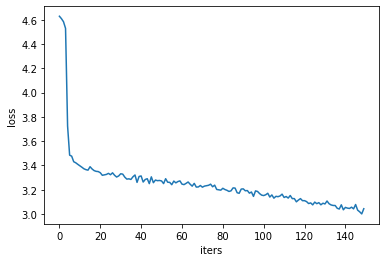

In [10]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()

In [11]:
all_losses

[tensor(4.6285, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.6084, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.5831, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.5288, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.7240, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.4845, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.4764, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.4305, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.4217, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.4089, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.3976, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.3852, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.3724, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.3651, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.3612, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.3894, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.3706, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.3573

#### Evaluation: A Sample of Generated Sequence

In [12]:
print(eval_step(net, predicted_len=600))

WWg:Siet b,n h n e rdii,eh :eap
pfus, mde
edgeal wded fri dei moru eow sd

t,nee incyd tyiaa c ohnecnhrp,sa y rfhou nyi
,k.e hi lory-ofn .eke tree ap ntrw l wh htlm hesyy or
 te ei noshot.IbfrV'SvARN,dtbnt  he ho
telie
e  rsr hyeen inpei iPke g ,n s
dhntncrC'yscha g nhr iio gds he tcoua oeum pTc  ha
e oee' yN lpiRurh lnllh  iL' h
gsp tAdme  s nt the mlrEtrI sffam  masOrnu scr;wsg msifeu teuxf o!nk,ofmtYo'slyw mast ret,t U stsr tviwt
o
 MMnwhy

h,igoar ss Arndvbter wtt tr tgeclrY
e;e ahtv olei'ayI z tan Adusan eWvyhad nwai.cekyernel sa:crtl mu thryteatm o;rr IThrfrnt? kn  eiwidames dllm'e p ,
aa


In [13]:
import numpy as np
f = open("original_RNN_tanh.npy", "w")

In [14]:
a = [data.item() for data in all_losses]

In [15]:
a

[4.62851619720459,
 4.608438491821289,
 4.583096027374268,
 4.528780937194824,
 3.724017858505249,
 3.4845492839813232,
 3.47636079788208,
 3.4305412769317627,
 3.4216933250427246,
 3.408937692642212,
 3.3976247310638428,
 3.3852431774139404,
 3.372422695159912,
 3.365116596221924,
 3.361177921295166,
 3.389373779296875,
 3.3706233501434326,
 3.357332706451416,
 3.351284980773926,
 3.349475383758545,
 3.340020179748535,
 3.318758249282837,
 3.322319984436035,
 3.3259217739105225,
 3.3347902297973633,
 3.323403835296631,
 3.339240312576294,
 3.3190510272979736,
 3.304561138153076,
 3.31335186958313,
 3.3313474655151367,
 3.3282430171966553,
 3.303713083267212,
 3.287297248840332,
 3.289727210998535,
 3.284700632095337,
 3.306334972381592,
 3.3214802742004395,
 3.2604708671569824,
 3.309093952178955,
 3.3133764266967773,
 3.263225555419922,
 3.284165620803833,
 3.2907819747924805,
 3.2501702308654785,
 3.3059844970703125,
 3.2575924396514893,
 3.2795324325561523,
 3.274491548538208,
 3.2

In [16]:
np.save("original_RNN_tanh.npy", a)

In [17]:
np.load("original_RNN_tanh.npy")

array([4.6285162 , 4.60843849, 4.58309603, 4.52878094, 3.72401786,
       3.48454928, 3.4763608 , 3.43054128, 3.42169333, 3.40893769,
       3.39762473, 3.38524318, 3.3724227 , 3.3651166 , 3.36117792,
       3.38937378, 3.37062335, 3.35733271, 3.35128498, 3.34947538,
       3.34002018, 3.31875825, 3.32231998, 3.32592177, 3.33479023,
       3.32340384, 3.33924031, 3.31905103, 3.30456114, 3.31335187,
       3.33134747, 3.32824302, 3.30371308, 3.28729725, 3.28972721,
       3.28470063, 3.30633497, 3.32148027, 3.26047087, 3.30909395,
       3.31337643, 3.26322556, 3.28416562, 3.29078197, 3.25017023,
       3.3059845 , 3.25759244, 3.27953243, 3.27449155, 3.27617812,
       3.27231336, 3.2503047 , 3.29060793, 3.26166821, 3.26055074,
       3.24135065, 3.27108574, 3.25653791, 3.26720715, 3.27263308,
       3.24613476, 3.24214053, 3.25220942, 3.2635839 , 3.24516439,
       3.22940993, 3.25221491, 3.22187543, 3.22273707, 3.23473382,
       3.22091603, 3.22971988, 3.23350787, 3.23641157, 3.24575

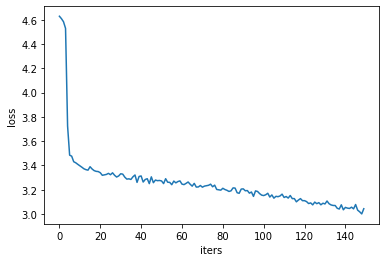

In [18]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(np.load("original_RNN_tanh.npy"))
plt.show()

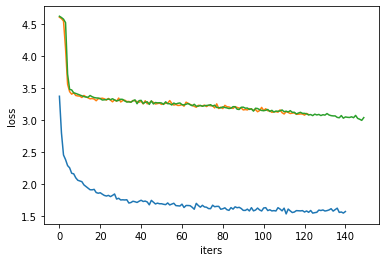

In [22]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(np.load("rnn_LSTM.npy"))
plt.plot(np.load("original_RNN.npy"))
plt.plot(np.load("original_RNN_tanh.npy"))
plt.show()


In [19]:
## experiment different plotting

In [20]:
a = np.random.choice(100, 100)
b = np.random.choice(100, 100)
y = np.arange(100) #length of the loss

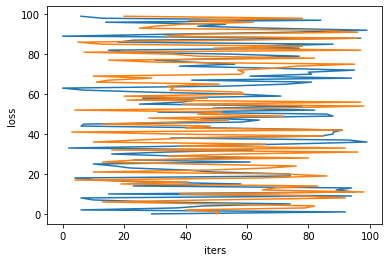

In [40]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(a, y)
plt.plot(b, y)
plt.show()